In [100]:
# 11/2/21

import pandas as pd
import xgboost as xgb
import numpy as np
import sklearn

In [119]:
df = pd.read_csv("src/data/processed/processed_all.csv")
df = df.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])

In [20]:
df[(df.current_hypotensive == 0) & (df.hypotensive_in_15 == 1.0)].shape[0] / df.shape[0]

0.047314598258831234

In [35]:
to_drop = df[(df.current_hypotensive == 1) & (df.hypotensive_in_15 == 1.0)]

In [23]:
df[(df.current_hypotensive == 0) & (df.hypotensive_in_15 == 0.0)].shape[0] / df.shape[0]

0.8002750603179296

In [24]:
df[(df.current_hypotensive == 1) & (df.hypotensive_in_15 == 0.0)].shape[0] / df.shape[0]

0.04716149366727732

In [30]:
df.all_values.iloc[0].split(" ... ").split

['[58.80002352 58.80002352 58.80002352',
 '86.40003456 86.40003456\n 85.20003408]']

In [120]:
new_df = df.drop(to_drop.index)

In [121]:
new_df["hypotensive_in_15"] = new_df["hypotensive_in_15"].astype(int)

In [124]:
# Add training labels
from src.utils.get_labels import get_training_labels

training_labels = get_training_labels()

new_df["training_label"] = new_df["wave"].apply(lambda x: training_labels[x])

In [53]:
new_df.to_csv("src/data/processed/processed_cleaned.csv", index=False)

## Building an XGBoost Model

In [126]:
from sklearn.pipeline import Pipeline

def run_pipeline(model, X_train, y_train, X_test, y_test):
    """Run pipeline in SKlearn to fit and make predictions with a model
    Parameters
    ----------
    model :
        Model to use
    X_train : np.array, shape=(nrows, ncolumns)
        Training features
    y_train : np.array, shape=(nrows,)
        Training label to predict
    X_test : np.array, shape=(nrows, ncolumns)
        Test features
    y_test : np.array, shape=(nrows,)
        Test label to predict
    Returns
    -------
    pipeline : sklearn.Pipeline object
        Pipeline of model
    pipeline_predictions : np.array(nrows)
        Predictions from model
    """
    pipeline = Pipeline(steps=[('m', model)])

    pipeline.fit(X_train, y_train)

    pipeline_predictions = pipeline.predict(X_test)

    print_metrics(pipeline, X_test, y_test, pipeline_predictions)

    return pipeline, pipeline_predictions

def run_stratified_pipeline(model, X, y, n_splits=5):
    """Run pipeline in SKlearn to cross-validate model
    Parameters
    ----------
    model :
        Model to use
    X : np.array, shape=(nrows, ncolumns)
        Unsplit features
    y : np.array, shape=(nrows,)
        Unsplit labels to predict
    n_splits : int, default=5
        # of splits for K-fold
    Returns
    -------
    pipeline : sklearn.Pipeline object
        Pipeline of model
    pipeline_predictions : np.array(nrows)
        Predictions from model
    """
    pipeline = make_pipeline(model)
    # Cross validate model
    cv = StratifiedKFold(n_splits=n_splits)
    n_scores = cross_validate(pipeline, X, y, scoring=("recall", "precision", "roc_auc"), cv=cv, error_score="raise")

    # report performance
    print('Recall: %.3f (%.3f)' % (np.mean(n_scores["test_recall"]), np.std(n_scores["test_recall"])))
    print('Precision: %.3f (%.3f)' % (np.mean(n_scores["test_precision"]), np.std(n_scores["test_precision"])))
    print('ROC_AUC: %.3f (%.3f)' % (np.mean(n_scores["test_roc_auc"]), np.std(n_scores["test_roc_auc"])))

    return pipeline, n_scores

def print_metrics(model, X_test, actual, predicted):
    """Output metrics from model
    
    Parameters
    ----------
    model : sklearn or xgboost object
        Model to evaluate
    X_test : np.array, shape=(nrows, ncolumns)
        Test features
    actual : np.array, shape=(nrows,)
        Test label to predict
    predict : np.array, shape=(nrows,)
        Label predictions from model
    
    Returns
    -------
    """
    metrics = sklearn.metrics.classification_report(actual, predicted)
    print(metrics)

    cm = sklearn.metrics.plot_confusion_matrix(model, X_test, actual)
    
    # Plot ROC curve
    roc = sklearn.metrics.plot_roc_curve(model, X_test, actual)
    
# Write a function to plot feature importances
    
def plot_feature_importances(feature_importance, std, columns):
    """Plot feature importances
    
    Parameters
    ----------
    feature_importance: np.array, shape=(ncols,)
        Array of feature importances
    std : np.array, shape=(ncols,)
        Standard deviations for feature importances
    columns : Pandas.Index
        Column names corresponding to feature_importance
    """
    forest_importances = pd.Series(feature_importance, index=columns)

    fig, ax = plt.subplots(figsize=(12, 7))
    sorted_idx = forest_importances.argsort()
    if not isinstance(std, type(None)):
        plt.barh(columns[sorted_idx], forest_importances[sorted_idx], xerr=std[sorted_idx])
    else:
        plt.barh(columns[sorted_idx], forest_importances[sorted_idx])
    ax.set_title("Feature importances")
    ax.set_xlabel("Mean decrease in impurity")
    fig.tight_layout()
    
    # Write a function to plot feature importances

In [127]:
## Convert wave data to numerical
new_df.wave, mapping = pd.factorize(new_df.wave)

In [60]:
## Split the data
## Need to split so that the train data has the earlier times
window_size = 60
n_windows = 15 / (window_size / 60) # Number of windows from now

'2017-09-14 18:17:02.088'

In [108]:
def split_by_time(df, split=0.7):
    """Split into training and testing DFs by time"""
    wave_ids = list(set(df.wave))
    train_splits = dict()
    # Get number of rows for each wave ID
    for ids in wave_ids:
        train_splits[ids] = len(df[df.wave == ids])
    
    # Split by 70% training, 30% testing
    # Designate first 70% of rows per wave to training
    train_df = pd.DataFrame().reindex_like(df)
    test_df = pd.DataFrame().reindex_like(df)
    train_idx = 0
    test_idx = 0
    for ids, count in train_splits.items():
        split = round(count * split)
        train = df[df.wave == ids].iloc[:split]
        test = df[df.wave == ids].iloc[split:]
        train_df.iloc[train_idx:(train_idx+len(train))] = train
        test_df.iloc[test_idx:(test_idx+len(test))] = test
        train_idx += len(train)
        test_idx += len(test)
        # Drop NAs
    train_df = train_df.dropna()
    test_df = test_df.dropna()
    
    return train_df, test_df

In [167]:
def split_by_patient(df, train_split=0.6, test_split=0.2):
    """Split into training and testing DFs by patients"""
    # Drop the pressor patients to begin with
    #df = df.drop(df[df.training_label == 'H1'].index)
    
    # Initialize training and testing sets
    train_df = pd.DataFrame().reindex_like(df)
    test_df = pd.DataFrame().reindex_like(df)
    valid_df = pd.DataFrame().reindex_like(df)
    train_idx = 0
    test_idx = 0
    valid_idx = 0
    for label in ("H2", "C1", "C2", "H1"):
        subset = df[df.training_label == label]
        wave_ids = list(set(subset.wave))
        n_ids = len(wave_ids)
        n_train = round(n_ids * train_split)
        n_test = round(n_ids * test_split)
        n_valid = n_ids - n_train - n_test
        train_ids = wave_ids[0:n_train]
        test_ids = wave_ids[n_train:n_train+n_test]
        valid_ids = wave_ids[n_train+n_test:n_ids]
        train_data = subset[subset.wave.isin(train_ids)]
        test_data = subset[subset.wave.isin(test_ids)]
        valid_data = subset[subset.wave.isin(valid_ids)]
        train_df.iloc[train_idx:(train_idx+len(train_data))] = train_data
        test_df.iloc[test_idx:(test_idx+len(test_data))] = test_data
        valid_df.iloc[valid_idx:(valid_idx+len(valid_data))] = valid_data 
        
        train_idx += len(train_data)
        test_idx += len(test_data)
        valid_idx += len(valid_data)
        
    # Drop NAs
    train_df = train_df.dropna()
    test_df = test_df.dropna()
    valid_df = valid_df.dropna()
    
    return train_df, test_df, valid_df

In [168]:
train_df, test_df, valid_df = split_by_patient(new_df)

In [169]:
# Set training and testing variables
y_train = np.array(train_df.hypotensive_in_15)
y_test = np.array(test_df.hypotensive_in_15)
X_train = train_df.drop(columns=["hypotensive_in_15", "all_values", "start_window_time", "end_window_time", "training_label"])
X_test = test_df.drop(columns=["hypotensive_in_15", "all_values", "start_window_time", "end_window_time", "training_label"])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:33:56] WARNING: ../src/learner.cc:576: 
Parameters: { "importance" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:33:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     71607
         1.0       0.18      0.04      0.06      3845

    accuracy                           0.94     75452
   macro avg       0.57      0.51      0.52     75452
weighted avg       0.91      0.94      0.92     75452



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


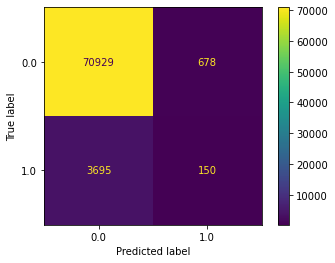

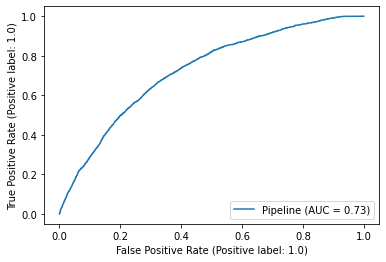

In [170]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=0, importance="weight")
xgb_pipeline, xgb_pipeline_predictions = run_pipeline(xgb,
                                                      X_train,
                                                      y_train,
                                                      X_test,
                                                      y_test)

## Hyperparameter Tuning

In [106]:
# Change below if necessary
PROJECT = !gcloud config get-value project  # noqa: E999
PROJECT = PROJECT[0]
BUCKET = "physionet_2009"
REGION = "us-central1"

%env PROJECT=$PROJECT
%env BUCKET=$BUCKET
%env REGION=$REGION

env: PROJECT=qwiklabs-gcp-04-133e595cc3fe
env: BUCKET=physionet_2009
env: REGION=us-central1


In [93]:
%%bash
# Output directory and job name
TIMESTAMP=$(date -u +%Y%m%d_%H%M%S)
BASE_OUTPUT_DIR=gs://${BUCKET}/taxifare_$TIMESTAMP
JOB_NAME=taxifare_$TIMESTAMP
echo ${BASE_OUTPUT_DIR} ${REGION} ${JOB_NAME}

# Vertex AI machines to use for training
PYTHON_PACKAGE_URI="gs://${BUCKET}/taxifare/taxifare_trainer-0.1.tar.gz"
MACHINE_TYPE="n1-standard-4"
REPLICA_COUNT=1
PYTHON_PACKAGE_EXECUTOR_IMAGE_URI="us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-5:latest"
PYTHON_MODULE="trainer.task"

# Model and training hyperparameters
BATCH_SIZE=15
NUM_EXAMPLES_TO_TRAIN_ON=100
NUM_EVALS=10
NBUCKETS=10
LR=0.001
NNSIZE="32 8"

# GCS paths
GCS_PROJECT_PATH=gs://$BUCKET/taxifare
DATA_PATH=$GCS_PROJECT_PATH/data
TRAIN_DATA_PATH=$DATA_PATH/taxi-train*
EVAL_DATA_PATH=$DATA_PATH/taxi-valid*


echo > ./config.yaml "displayName: $JOB_NAME
studySpec:
  metrics:
  - metricId: val_rmse
    goal: MINIMIZE
  parameters:
  - parameterId: lr
    doubleValueSpec:
      minValue: 0.0001
      maxValue: 0.1
    scaleType: UNIT_LOG_SCALE
  - parameterId: nbuckets
    integerValueSpec:
      minValue: 10
      maxValue: 25
    scaleType: UNIT_LINEAR_SCALE
  - parameterId: batch_size
    discreteValueSpec:
      values:
      - 15
      - 30
      - 50
    scaleType: UNIT_LINEAR_SCALE
  algorithm: ALGORITHM_UNSPECIFIED # results in Bayesian optimization
trialJobSpec:
  baseOutputDirectory:
    outputUriPrefix: $BASE_OUTPUT_DIR
  workerPoolSpecs:
  - machineSpec:
      machineType: $MACHINE_TYPE
    pythonPackageSpec:
      args:
      - --train_data_path=$TRAIN_DATA_PATH
      - --eval_data_path=$EVAL_DATA_PATH
      - --batch_size=$BATCH_SIZE
      - --num_examples_to_train_on=$NUM_EXAMPLES_TO_TRAIN_ON
      - --num_evals=$NUM_EVALS
      - --nbuckets=$NBUCKETS
      - --lr=$LR
      - --nnsize=$NNSIZE
      executorImageUri: $PYTHON_PACKAGE_EXECUTOR_IMAGE_URI
      packageUris:
      - $PYTHON_PACKAGE_URI
      pythonModule: $PYTHON_MODULE
    replicaCount: $REPLICA_COUNT"

0          0
1          0
2          0
3          0
4          0
          ..
378771    53
378775    53
378777    53
378784    53
378815    53
Name: wave, Length: 338955, dtype: int64

In [113]:
min(df.index)

0